###menyambungkan gdrive ke colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###import dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Colab Notebooks/datasetraden/'):
    for filename in filenames:
        images.append(os.path.join(filename).split('/')[-1])
        label.append(os.path.join(dirname).split('/')[-1])

###import library yang akan digunakan

In [ ]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from PIL import Image
import random
import time
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###memperlihatkan dataset dan label

In [ ]:
IMAGE = '/content/gdrive/MyDrive/Colab Notebooks/datasetraden/'
TARGET_LABEL = {'cataract': 0,
                'diabetic_retinopathy': 1,
                'glaucoma': 2,
                'normal': 3}

df = pd.DataFrame({'image':images, 'label': label})
df

,image,label
0,103_left.jpg,cataract
1,0_left.jpg,cataract
2,2200_left.jpg,cataract
3,2101_right.jpg,cataract
4,2232_right.jpg,cataract
...,...,...
3995,129_left (719).jpg,diabetic_retinopathy
3996,129_left (837).jpg,diabetic_retinopathy
3997,129_left (11).jpg,diabetic_retinopathy
3998,129_left (342).jpg,diabetic_retinopathy


###menunjukkan presentase sebaran data

<ipython-input-5-273ed2dae6bc>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


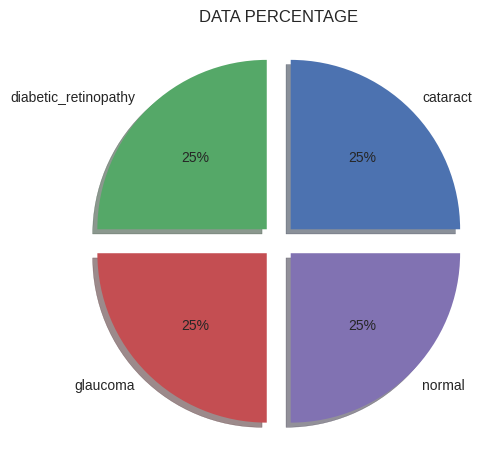

In [ ]:
label, count = np.unique(df['label'].values, return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = label, explode=[0.1, 0.1, 0.1, 0.1],  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

###mempersiapkan fungsi untuk memuat dataset

In [ ]:
class Penyakit(Dataset):
    def __init__(self, x, y, path, map_label=TARGET_LABEL, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.X)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image'].values, df['label'].values,
    test_size=0.15, stratify=df['label'].values,
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    stratify=y_trainval, test_size=0.15,
    random_state=77)
len(X_train), len(X_val), len(X_test)

(2890, 510, 600)

###memuat dataset

In [ ]:
#DATALOADER
mean = [0.5548598 , 0.54704523, 0.54043627]
std = [0.1071739 , 0.10524916, 0.10435305]
batch_size = 16

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Penyakit(X_train, y_train, IMAGE, transform=train_transform)
val_set = Penyakit(X_val, y_val, IMAGE, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                           num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False,
                                         num_workers=0, pin_memory=True)

###menunjukkan isi dari data training secara random

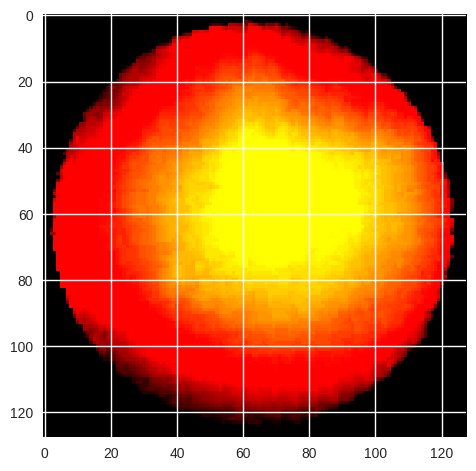

In [ ]:
img, label = train_set[random.randint(1, len(X_train))]

plt.imshow(img.permute(1,2,0))

###memuat model MobileNetV3-Small dan penambahan teknik squeeze-and-excitation
memuat resnet dengan 1024 Neuron dan 4 class

In [ ]:
import torch
import torch.nn as nn
import torchvision

# Definisikan kelas SEBlock
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Definisikan model dengan fitur Squeeze-and-Excitation
class MobileNetV3WithSE(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3WithSE, self).__init__()
        self.base_model = torchvision.models.mobilenet_v3_small(pretrained=True)
        self.se_block = SEBlock(1024)  # Sesuaikan dengan jumlah fitur keluaran dari model dasar
        self.fc = nn.Linear(1024, num_classes, bias=True)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.se_block(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x

# Inisialisasi model dan gunakan
num_classes = 4  # Sesuaikan dengan jumlah kelas Anda
model_with_se = MobileNetV3WithSE(num_classes)

# Jika Anda ingin menggunakan perangkat GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_with_se.to(device)

# Cetak model untuk melihat strukturnya
print(model_with_se)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 30.8MB/s]

MobileNetV3WithSE(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          

###menyiapkan fungsi untuk menampung data akurasi dari proses training

akurasi = jumlah prediksi benar : jumlah total melakukan prediksi

In [ ]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

NameError: name 'model' is not defined

###proses training model neural network

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
times = []
for e in range(epoch):
    model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()

        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)

        train_loss += loss
        train_acc += accuracy(output, label)

        loss.backward()
        optimizer.step()
        scheduler.step()

    else:
        with torch.no_grad():
            model.eval()

            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss

    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))

    times.append(time.time() - since)

    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

print(sum(times))

In [ ]:
time_str = float(sum(times))
print('total waktu {:.3f} s'.format(time_str))
# print(time_str)

###menampilkan grafik akurasi menggunakan matplotlib

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

###menampilkan grafik loss menggunakan matplotlib

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('loss')
plt.ylabel('loss'); plt.xlabel('epoch')
plt.legend()
plt.show()

###proses pengujian data

In [ ]:
test_set = Penyakit(X_test, y_test, IMAGE, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

###menampilkan hasil pengujian data secara acak

In [ ]:
ints_2_label = {0: 'cataract',
                1: 'diabetic_retinopathy',
                2: 'glaucoma',
                3: 'normal'}

random_selection = np.random.randint(0, len(test_predict), 20)

fig = plt.figure(figsize=(20, 10))

test_set = Penyakit(X_test, y_test, IMAGE, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(5, 4, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(ints_2_label[label], ints_2_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=16)

plt.tight_layout() #want faster comment or delete this
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, fmt='d', cmap='GnBu', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit

plt.xticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.yticks(ticks=np.arange(0.5, len(list(TARGET_LABEL.keys()))), labels = list(TARGET_LABEL.keys()))
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))